In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

In [2]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"


In [3]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.99))]
basis = "sto-3g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")

nqbits = rdm1.shape[0] * 2
print("Number of qubits = ", nqbits)

 HF energy :  -1.0688975010368336
 MP2 energy : -1.0891124176527813
 FCI energy : -1.103247661224499

Number of qubits before active space selection = 4
Number of qubits =  4


/home/huybinh/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.chemistry.ucc import (
    guess_init_params,
    get_hf_ket,
    get_cluster_ops,
)

# Wrap the hamiltonian data into the `MolecularHamiltonian` class.
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)


molecule = MoleculeInfo(hamiltonian=mol_h, n_electrons=n_electrons, noons = False,  orbital_energies=orbital_energies)
print(molecule.nqbits)

4


In [5]:
# Computation of the initial parameters
theta_init = guess_init_params(
    molecule.two_body_integrals,
    molecule.n_electrons,
    molecule.orbital_energies,
)

# Define the initial Hartree-Fock state
ket_hf_init = get_hf_ket(molecule.n_electrons, nqbits=molecule.nqbits)

# Compute the cluster operators
cluster_ops = get_cluster_ops(molecule.n_electrons, nqbits=molecule.nqbits)


# Get the ElectronicStructureHamiltonian
H = molecule.hamiltonian.get_electronic_hamiltonian()


In [6]:
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code, recode_integer

transformation, code = transform_to_jw_basis, get_jw_code

H_sp = transformation(H)
model = H_sp
nqbits = model.nbqbits

# Express the cluster operator in spin terms
cluster_ops_sp = [transformation(t_o) for t_o in cluster_ops]

# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, code(nqbits))


print("This model has the number of qubit:", model.nbqbits)
print("The number of excitation for this model", len(cluster_ops_sp))
print(model)

This model has the number of qubit: 4
The number of excitation for this model 3
(-0.3215821345068788+0j) * I^4 +
(0.15704511695409992+0j) * (ZZ|[0, 1]) +
(0.1067602885375726+0j) * (ZZ|[0, 2]) +
(0.1557997832872776+0j) * (ZZ|[1, 2]) +
(0.1557997832872776+0j) * (ZZ|[0, 3]) +
(0.1382949122525399+0j) * (Z|[0]) +
(0.1067602885375726+0j) * (ZZ|[1, 3]) +
(0.13829491225253987+0j) * (Z|[1]) +
(0.049039494749704995+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.049039494749704995+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.049039494749704995+0j) * (YYXX|[0, 1, 2, 3]) +
(0.049039494749704995+0j) * (YXXY|[0, 1, 2, 3]) +
(0.16366861628421733+0j) * (ZZ|[2, 3]) +
(-0.13315956580674568+0j) * (Z|[2]) +
(-0.13315956580674568+0j) * (Z|[3])


In [7]:
model_matrix_sp = model.get_matrix(sparse=True)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(model_matrix_sp, k=14)
print(eigval)
#print(eigvec)

[-1.10324766  0.51398105  0.53452244 -0.3480589  -0.60479546 -0.58127777
  0.05127057 -0.05161581 -0.58127777 -0.60479546 -0.05161581 -0.74037486
 -0.74037486 -0.74037486]


In [8]:

import itertools
from typing import Any, List, Tuple, Optional, Dict
from bitstring import BitArray
import numpy as np

from qat.core import Term
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X

from qat.fermion.trotterisation import make_spin_hamiltonian_trotter_slice
from qat.fermion.hamiltonians import SpinHamiltonian, FermionHamiltonian
from qat.fermion.util import tobin

def two_loc(
    cluster_ops: List[SpinHamiltonian],
    theta: List[float],
    k: int, # number of excitations
    n_cycles: int = 1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
      
) -> Circuit:
    

    nqbits = cluster_ops[0].nbqbits

    prog = Program()
    reg = prog.qalloc(nqbits)

    # Initialize the Hartree-Fock state into the Program
    for j, char in enumerate(tobin(k, nqbits)):
        if char == "1":
            prog.apply(X, reg[j])
        if char == "0":
            prog.apply(I, reg[j])
    

    print("This applied state is ", tobin(k, nqbits))
    # Define the parameters to optimize

    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)


    ind_theta = 0


    for i in range(nqbits):

        for rot in rotation_gates:

            prog.apply(rot(theta[ind_theta]), reg[i])
            ind_theta += 1
    
    for k in range(n_cycles):


        for i in range(nqbits - 1):
            for j in range(i+1, nqbits):
                prog.apply(CNOT, reg[i], reg[j])
            
        for i in range(nqbits):
            for rot in rotation_gates:
                            
                prog.apply(rot(theta[ind_theta]), reg[i])
                ind_theta += 1

    return prog.to_circ()

In [9]:
n_rotations = 2
n_cycles =3
prog = Program()


rotation_gates = [RY,RZ]

entangling_gate = CNOT

k_lst = [0]

theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(len(theta_0))]

def create_circuit(k):
    return two_loc(cluster_ops_sp, theta, k, n_cycles, rotation_gates, entangling_gate)

# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits

for circ_dis in circuits_store:
    circ_dis.display()


This applied state is  0000


In [10]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
nqbits = model.nbqbits

energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
           
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

        return energy
    
    return input_funct

circuits = circuits_store


input_funct = opt_funct(circuits, model, qpu, nqbits, energy_lists)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, options=options)

print(Optimizer)




Optimization terminated successfully.
         Current function value: -1.103248
         Iterations: 57
         Function evaluations: 2700
         Gradient evaluations: 60
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.1032476612244555
        x: [ 3.488e+00 -2.392e-08 ...  8.429e-01  5.287e+00]
      nit: 57
      jac: [ 2.980e-08 -1.490e-08 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 2.473e+00 -3.138e-01 ... -2.563e-05 -8.041e-04]
            [-3.138e-01  1.249e+00 ...  6.620e-06  2.319e-04]
            ...
            [-2.563e-05  6.620e-06 ...  1.000e+00 -1.178e-09]
            [-8.041e-04  2.319e-04 ... -1.178e-09  1.000e+00]]
     nfev: 2700
     njev: 60


Final energy for k=0000: [-0.22285221513991016, -0.22285221529884303, -0.22285221187814486, -0.22285221681305328, -0.22285221475000067, -0.22285221449491543, -0.22285221275482817, -0.22285221367538277, -0.22285221656187232, -0.22285221397391164, -0.22285221270098016, -0.22285221596845728, -0.22285221651184334, -0.2228522143400682, -0.22285221671189026, -0.2228522147231451, -0.22285221327912674, -0.22285221328100835, -0.22285221527024585, -0.2228522144258841, -0.2228522151623354, -0.22285221572549127, -0.2228522150095747, -0.22285221700323354, -0.22285221527037313, -0.22285221511748515, -0.22285221528293186, -0.22285221545511302, -0.22285221520931867, -0.2228522146957857, -0.22285221360100754, -0.2228522105439532, -0.22285221431470792, -0.22285221513991016, -0.22285221513991016, -0.2228522151399102, -0.2228522151399102, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.222852215139

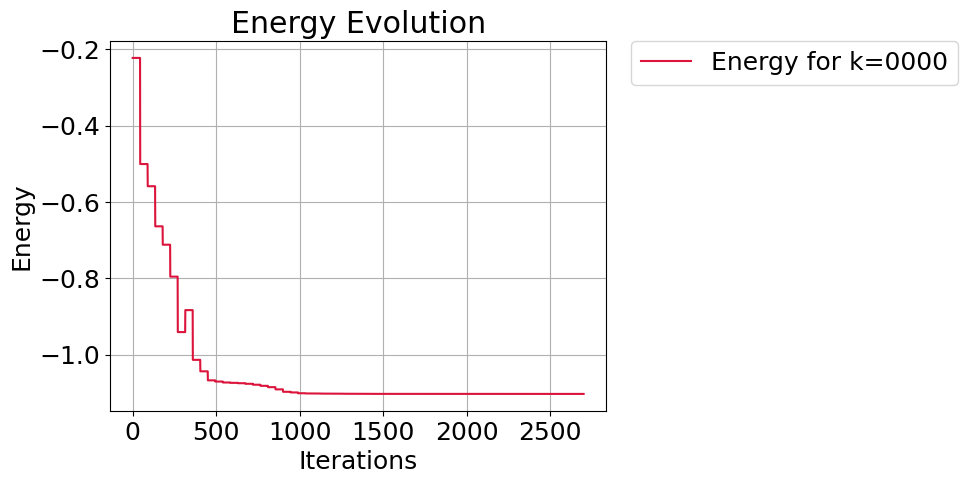

In [11]:
import matplotlib.pyplot as plt
# Plot energy
plt.rcParams["font.size"] = 18
all_energy_lists = []

for i in range(len(circuits_store)):
    energy_list = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_list)
    plt.plot(range(len(energy_list)), energy_list, label=f"Energy for k={binary_repr(k_lst[i]).zfill(4)}", color='crimson')

    # Print the final energy for each k
    final_energy = energy_list
    print(f"Final energy for k={binary_repr(k_lst[i]).zfill(4)}: {final_energy}")

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.grid(True)
plt.show()

In [12]:
opt_circ_ground = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})
#print(opt_circ_ground)
theta_star = {k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)}
print("List of the update theta", theta_star)


result = qpu.submit(opt_circ_ground.to_job())
nbqbits = model.nbqbits

def get_statevector(result, nbqbits):
    statevector = []
    for sample in result:
        statevector.append({
            'state': sample.state,
            'amplitude': sample.amplitude
        })
    return statevector

    

def get_statevector_matrix(result, nbqbits):

    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

stv_ground = get_statevector(result, nbqbits)
print(stv_ground)

stv_ground_mat= get_statevector_matrix(result, nbqbits)
print(stv_ground_mat)

List of the update theta {'\\theta_{0}': 3.488306669900616, '\\theta_{10}': -2.3919473528409843e-08, '\\theta_{11}': 4.417002014699782, '\\theta_{12}': 4.712389004570996, '\\theta_{13}': 2.600708085482741, '\\theta_{14}': 3.141592227305061, '\\theta_{15}': 4.002585289642834, '\\theta_{16}': 3.1415925328283394, '\\theta_{17}': 4.216019853984586, '\\theta_{18}': 1.0150415942976787, '\\theta_{19}': 6.2831851401343, '\\theta_{1}': 0.35569816730998843, '\\theta_{20}': 6.283184467526328, '\\theta_{21}': 4.712389374074313, '\\theta_{22}': 6.283184375189996, '\\theta_{23}': 5.25327383469949, '\\theta_{24}': 3.141592796609361, '\\theta_{25}': 1.3853914369339804, '\\theta_{26}': 4.156634203159773, '\\theta_{27}': 3.375733783014781, '\\theta_{28}': 1.5707965245869397, '\\theta_{29}': 3.996360150117585, '\\theta_{2}': 6.28318533902999, '\\theta_{30}': 3.1415930529590734, '\\theta_{31}': 1.0334140626741903, '\\theta_{3}': 2.6778875839773253, '\\theta_{4}': 3.141593097970544, '\\theta_{5}': 3.292850

In [13]:
#More style
from tabulate import tabulate

# Print the statevector nicely in columns
print(tabulate(stv_ground, headers="keys", tablefmt="pretty"))

+--------+---------------------------------------------------+
| state  |                     amplitude                     |
+--------+---------------------------------------------------+
| |0000> | (-1.4716368004354973e-09-2.6937270984037157e-08j) |
| |0001> |  (7.491553187647856e-09-3.5081157226285734e-08j)  |
| |0010> | (-1.4275956768673732e-08+1.4803169025846686e-07j) |
| |0011> |    (0.00433809822958546-0.17243544575868164j)     |
| |0100> | (-4.5416667063412287e-08+2.9449051783687364e-08j) |
| |0101> | (-4.0245315187566604e-08+2.9407133456389517e-08j) |
| |0110> | (2.7450151497351093e-09+1.0322307919486939e-10j)  |
| |0111> | (-1.0840436031235708e-08-6.866544332651474e-09j)  |
| |1000> | (-7.293879544740237e-08-7.0493661006643965e-09j)  |
| |1001> |  (9.569353043935723e-09-1.2429563470632353e-08j)  |
| |1010> |   (-2.982362332922572e-08-3.5144647401251e-08j)   |
| |1011> |   (1.85124969524775e-08-3.866186732564455e-08j)   |
| |1100> |     (-0.0247729325285162+0.9846997002963067j

In [14]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
method = "BFGS"
beta_small = 33
nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None:
                    total_energy = energy + beta_small * overlap_inp 

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)


    return input_funct, callback
    

    

circuits = circuits_store

input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 71
         Function evaluations: 3375
         Gradient evaluations: 75
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.7403748572445789
        x: [ 4.639e+00  6.533e-07 ...  8.429e-01  5.287e+00]
      nit: 71
      jac: [-7.451e-09  1.490e-08 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 8.769e+00 -3.662e+00 ...  1.155e-03 -7.921e-03]
            [-3.662e+00  8.291e+01 ... -3.042e-03  2.837e-02]
            ...
            [ 1.155e-03 -3.042e-03 ...  1.000e+00 -1.087e-05]
            [-7.921e-03  2.837e-02 ... -1.087e-05  1.000e+00]]
     nfev: 3375
     njev: 75


Final energy for k=1010: [-0.2228522151399102, -0.22285221529884308, -0.22285221187814486, -0.22285221681305323, -0.22285221475000067, -0.22285221449491543, -0.22285221275482817, -0.22285221367538274, -0.2228522165618723, -0.22285221397391164, -0.22285221270098016, -0.22285221596845728, -0.22285221651184334, -0.2228522143400682, -0.22285221671189026, -0.2228522147231451, -0.22285221327912674, -0.22285221328100835, -0.2228522152702459, -0.2228522144258842, -0.2228522151623354, -0.22285221572549127, -0.2228522150095747, -0.2228522170032335, -0.2228522152703731, -0.22285221511748515, -0.22285221528293186, -0.222852215455113, -0.22285221520931872, -0.2228522146957857, -0.22285221360100754, -0.22285221054395318, -0.22285221431470792, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.22285221513991016, -0.2228522151399102, -0.2228522151399102, -0.22285221513991016, -0.22285221513991016,

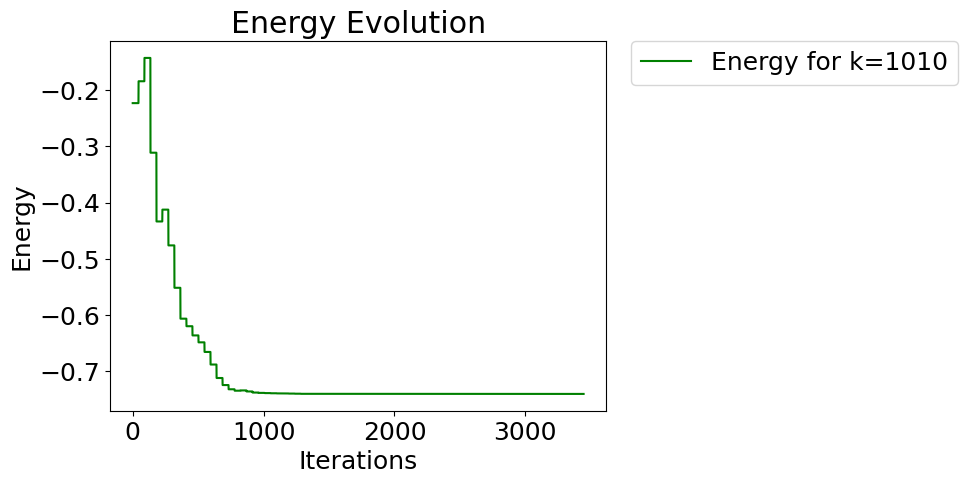

In [15]:
# Plot energy
plt.rcParams["font.size"] = 18
all_energy_lists = []

for i in range(len(circuits_store)):
    energy_list = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_list)
    plt.plot(range(len(energy_list)), energy_list, label=f"Energy for k={binary_repr(10).zfill(4)}", color = 'green')

    # Print the final energy for each k
    final_energy = energy_list
    print(f"Final energy for k={binary_repr(10).zfill(4)}: {final_energy}")

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

In [16]:
opt_circ_exci = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ_exci.to_job())
nbqbits = model.nbqbits

stv_exci = get_statevector(result, nbqbits)

stv_exci_mat= get_statevector_matrix(result, nbqbits)
print(stv_exci_mat)

[-2.61085303e-08+5.11720310e-08j -1.45095538e-08-1.82179521e-09j
  2.07575180e-09+9.22614640e-09j -7.64178735e-09+3.34577868e-08j
 -1.46311063e-07+3.66535661e-09j -2.77729205e-01+2.41928937e-01j
 -2.19877453e-01+5.39551864e-01j  7.55675361e-09+4.56134081e-08j
 -7.26945288e-08+2.13335009e-07j -2.19877486e-01+5.39551914e-01j
 -2.41642485e-02-4.29916600e-01j -2.49424910e-08-4.73821923e-08j
  5.47525114e-09-1.00925481e-08j -5.43622932e-09-1.35978254e-08j
 -1.18434248e-08+9.12861985e-09j -3.24178465e-08+9.61491959e-09j]


In [17]:
#More style
from tabulate import tabulate

# Print the statevector nicely in columns
print(tabulate(stv_exci, headers="keys", tablefmt="pretty"))

+--------+---------------------------------------------------+
| state  |                     amplitude                     |
+--------+---------------------------------------------------+
| |0000> | (-2.6108530327177456e-08+5.1172031020628584e-08j) |
| |0001> | (-1.4509553807319593e-08-1.821795208203451e-09j)  |
| |0010> |  (2.0757518038748413e-09+9.22614639777892e-09j)   |
| |0011> |  (-7.641787352392169e-09+3.345778680777986e-08j)  |
| |0100> | (-1.463110633520185e-07+3.6653566102974966e-09j)  |
| |0101> |    (-0.27772920512122157+0.24192893732992593j)    |
| |0110> |    (-0.21987745281092833+0.5395518636694383j)     |
| |0111> |   (7.5567536082148e-09+4.561340806687584e-08j)    |
| |1000> |  (-7.269452879699827e-08+2.133350089554166e-07j)  |
| |1001> |    (-0.21987748625489498+0.5395519137132833j)     |
| |1010> |    (-0.02416424850531035-0.4299165995888189j)     |
| |1011> |  (-2.4942491038803536e-08-4.73821923085992e-08j)  |
| |1100> |  (5.475251143782055e-09-1.0092548085800051e-

In [18]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
def_stv_exci = stv_exci_mat

beta_small = 33
beta_big = 44
nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, def_stv, def_stv_exci):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None and overlap_inp_exci is not None:
                    total_energy = energy + beta_small * overlap_inp + beta_big * overlap_inp_exci

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)


    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big,  def_stv, def_stv_exci)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 110
         Function evaluations: 5265
         Gradient evaluations: 117
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.7403748572445675
        x: [ 4.712e+00  6.861e-01 ...  8.429e-01  5.287e+00]
      nit: 110
      jac: [-2.980e-08  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 7.520e+00  3.647e+00 ...  3.522e-04 -1.267e-04]
            [ 3.647e+00  5.762e+00 ...  1.925e-04  1.340e-03]
            ...
            [ 3.522e-04  1.925e-04 ...  1.000e+00 -5.249e-07]
            [-1.267e-04  1.340e-03 ... -5.249e-07  1.000e+00]]
     nfev: 5265
     njev: 117


In [22]:
#  Desired error not necessarily achieved due to precision loss.

In [23]:
opt_circ_exci_t = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ_exci_t.to_job())
nbqbits = model.nbqbits

stv_exci_t = get_statevector(result, nbqbits)

stv_exci_mat_t= get_statevector_matrix(result, nbqbits)
print(stv_exci_mat_t)

[ 1.61458617e-08+1.61067881e-08j  5.53223487e-09+1.02284714e-08j
 -6.09507902e-08-8.99416490e-09j  7.23216505e-08-2.23035681e-08j
 -1.68051677e-08+1.41945012e-08j  2.78199503e-01+5.15041198e-01j
 -2.83735854e-01-2.77185238e-01j  9.61736270e-09+9.43780900e-09j
  2.36203390e-08+1.66328408e-09j -2.83735737e-01-2.77185196e-01j
 -5.21397519e-01-2.66095726e-01j -9.56890009e-09-6.03563943e-09j
 -2.86080735e-08-3.02300078e-08j -1.01035011e-07+1.96644213e-08j
  1.65888214e-07-5.51148200e-08j  9.57998371e-08-8.17029594e-08j]


In [24]:
#More style
from tabulate import tabulate

# Print the statevector nicely in columns
print(tabulate(stv_exci_t, headers="keys", tablefmt="pretty"))

+--------+---------------------------------------------------+
| state  |                     amplitude                     |
+--------+---------------------------------------------------+
| |0000> |  (1.6145861747936736e-08+1.610678808447729e-08j)  |
| |0001> |  (5.532234869161243e-09+1.0228471406901812e-08j)  |
| |0010> |  (-6.095079015164891e-08-8.994164903214085e-09j)  |
| |0011> |   (7.232165054783842e-08-2.23035680687625e-08j)   |
| |0100> | (-1.680516768246167e-08+1.4194501236815363e-08j)  |
| |0101> |     (0.2781995034710595+0.5150411977324223j)      |
| |0110> |    (-0.28373585420793446-0.2771852383374962j)     |
| |0111> |   (9.617362700172382e-09+9.43780900331017e-09j)   |
| |1000> |  (2.362033896067289e-08+1.6632840776225204e-09j)  |
| |1001> |     (-0.2837357368914513-0.2771851959542043j)     |
| |1010> |     (-0.5213975189093237-0.2660957264239924j)     |
| |1011> |  (-9.56890009075629e-09-6.035639431739482e-09j)   |
| |1100> | (-2.8608073495925374e-08-3.023000784162546e-

In [25]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
def_stv_exci = stv_exci_mat
def_stv_exci_t = stv_exci_mat_t

beta_small = 33
beta_big = 44
beta_bigger = 55

nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, def_stv, def_stv_exci, def_stv_exci_t):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None and overlap_inp_exci is not None:
                    total_energy = energy + beta_small * overlap_inp + beta_big * overlap_inp_exci + beta_bigger * overlap_inp_exci_t

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)


    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, def_stv, def_stv_exci, def_stv_exci_t )
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

         Current function value: -0.604795
         Iterations: 239
         Function evaluations: 12296
         Gradient evaluations: 273
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.6047954583230982
        x: [ 3.142e+00  7.809e-01 ...  8.428e-01  5.287e+00]
      nit: 239
      jac: [ 0.000e+00 -1.490e-08 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 1.457e+00 -2.114e-01 ...  1.109e-03  1.316e-03]
            [-2.114e-01  1.514e+01 ... -4.289e-02 -4.789e-02]
            ...
            [ 1.109e-03 -4.289e-02 ...  1.000e+00  1.504e-04]
            [ 1.316e-03 -4.789e-02 ...  1.504e-04  1.000e+00]]
     nfev: 12296
     njev: 273


/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [26]:
opt_circ_exci_q = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ_exci_q.to_job())
nbqbits = model.nbqbits

stv_exci_q = get_statevector(result, nbqbits)

stv_exci_mat_q= get_statevector_matrix(result, nbqbits)

print(stv_exci_mat_q)

[ 1.61458617e-08+1.61067881e-08j  5.53223487e-09+1.02284714e-08j
 -6.09507902e-08-8.99416490e-09j  7.23216505e-08-2.23035681e-08j
 -1.68051677e-08+1.41945012e-08j  2.78199503e-01+5.15041198e-01j
 -2.83735854e-01-2.77185238e-01j  9.61736270e-09+9.43780900e-09j
  2.36203390e-08+1.66328408e-09j -2.83735737e-01-2.77185196e-01j
 -5.21397519e-01-2.66095726e-01j -9.56890009e-09-6.03563943e-09j
 -2.86080735e-08-3.02300078e-08j -1.01035011e-07+1.96644213e-08j
  1.65888214e-07-5.51148200e-08j  9.57998371e-08-8.17029594e-08j]


In [27]:
#More style
from tabulate import tabulate

# Print the statevector nicely in columns
print(tabulate(stv_exci_q, headers="keys", tablefmt="pretty"))

+--------+---------------------------------------------------+
| state  |                     amplitude                     |
+--------+---------------------------------------------------+
| |0000> |  (1.6145861747936736e-08+1.610678808447729e-08j)  |
| |0001> |  (5.532234869161243e-09+1.0228471406901812e-08j)  |
| |0010> |  (-6.095079015164891e-08-8.994164903214085e-09j)  |
| |0011> |   (7.232165054783842e-08-2.23035680687625e-08j)   |
| |0100> | (-1.680516768246167e-08+1.4194501236815363e-08j)  |
| |0101> |     (0.2781995034710595+0.5150411977324223j)      |
| |0110> |    (-0.28373585420793446-0.2771852383374962j)     |
| |0111> |   (9.617362700172382e-09+9.43780900331017e-09j)   |
| |1000> |  (2.362033896067289e-08+1.6632840776225204e-09j)  |
| |1001> |     (-0.2837357368914513-0.2771851959542043j)     |
| |1010> |     (-0.5213975189093237-0.2660957264239924j)     |
| |1011> |  (-9.56890009075629e-09-6.035639431739482e-09j)   |
| |1100> | (-2.8608073495925374e-08-3.023000784162546e-

In [28]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
def_stv_exci = stv_exci_mat
def_stv_exci_t = stv_exci_mat_t
def_stv_exci_q = stv_exci_mat_q

beta_small = 33
beta_big = 44
beta_bigger = 55
beta_biggest = 66

nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, beta_biggest, def_stv, def_stv_exci, def_stv_exci_t, def_stv_exci_q):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)
                overlap_inp_exci_q = overlap(bound_circ, def_stv_exci_q)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None and overlap_inp_exci is not None:
                    total_energy = energy + beta_small * overlap_inp + beta_big * overlap_inp_exci + beta_bigger * overlap_inp_exci_t + beta_biggest * overlap_inp_exci_q

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)
                overlap_inp_exci_q = overlap(bound_circ, def_stv_exci_q)


    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, beta_biggest, def_stv, def_stv_exci, def_stv_exci_t, def_stv_exci_q)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

         Current function value: -0.604795
         Iterations: 128
         Function evaluations: 6975
         Gradient evaluations: 155
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.6047954583396843
        x: [ 3.142e+00  1.828e-06 ...  8.429e-01  5.287e+00]
      nit: 128
      jac: [-7.451e-09  1.036e-06 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 2.548e+00  1.077e+00 ...  2.564e-05 -1.461e-05]
            [ 1.077e+00  2.366e+01 ... -3.218e-04 -1.288e-04]
            ...
            [ 2.564e-05 -3.218e-04 ...  1.000e+00 -2.847e-09]
            [-1.461e-05 -1.288e-04 ... -2.847e-09  1.000e+00]]
     nfev: 6975
     njev: 155


/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [29]:
opt_circ_exci_k= circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ_exci_k.to_job())
nbqbits = model.nbqbits

stv_exci_k = get_statevector(result, nbqbits)

stv_exci_mat_k= get_statevector_matrix(result, nbqbits)

print(stv_exci_mat_k)

[ 1.61458617e-08+1.61067881e-08j  5.53223487e-09+1.02284714e-08j
 -6.09507902e-08-8.99416490e-09j  7.23216505e-08-2.23035681e-08j
 -1.68051677e-08+1.41945012e-08j  2.78199503e-01+5.15041198e-01j
 -2.83735854e-01-2.77185238e-01j  9.61736270e-09+9.43780900e-09j
  2.36203390e-08+1.66328408e-09j -2.83735737e-01-2.77185196e-01j
 -5.21397519e-01-2.66095726e-01j -9.56890009e-09-6.03563943e-09j
 -2.86080735e-08-3.02300078e-08j -1.01035011e-07+1.96644213e-08j
  1.65888214e-07-5.51148200e-08j  9.57998371e-08-8.17029594e-08j]


In [30]:
#More style
from tabulate import tabulate

# Print the statevector nicely in columns
print(tabulate(stv_exci_k, headers="keys", tablefmt="pretty"))

+--------+---------------------------------------------------+
| state  |                     amplitude                     |
+--------+---------------------------------------------------+
| |0000> |  (1.6145861747936736e-08+1.610678808447729e-08j)  |
| |0001> |  (5.532234869161243e-09+1.0228471406901812e-08j)  |
| |0010> |  (-6.095079015164891e-08-8.994164903214085e-09j)  |
| |0011> |   (7.232165054783842e-08-2.23035680687625e-08j)   |
| |0100> | (-1.680516768246167e-08+1.4194501236815363e-08j)  |
| |0101> |     (0.2781995034710595+0.5150411977324223j)      |
| |0110> |    (-0.28373585420793446-0.2771852383374962j)     |
| |0111> |   (9.617362700172382e-09+9.43780900331017e-09j)   |
| |1000> |  (2.362033896067289e-08+1.6632840776225204e-09j)  |
| |1001> |     (-0.2837357368914513-0.2771851959542043j)     |
| |1010> |     (-0.5213975189093237-0.2660957264239924j)     |
| |1011> |  (-9.56890009075629e-09-6.035639431739482e-09j)   |
| |1100> | (-2.8608073495925374e-08-3.023000784162546e-

In [32]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
def_stv = stv_ground_mat
def_stv_exci = stv_exci_mat
def_stv_exci_t = stv_exci_mat_t
def_stv_exci_q = stv_exci_mat_q
def_stv_exci_k = stv_exci_mat_k


beta_small = 33
beta_big = 44
beta_bigger = 55
beta_biggest = 66
beta_huge = 77

nqbits = 4

def get_statevector_matrix(result, nbqbits):
    statevector_mat = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nbqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, beta_biggest, beta_huge, def_stv, def_stv_exci, def_stv_exci_t, def_stv_exci_q, def_stv_exci_k):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)
                overlap_inp_exci_q = overlap(bound_circ, def_stv_exci_q)
                overlap_inp_exci_k = overlap(bound_circ, def_stv_exci_k)
                

                # Check if overlap_inp is not None
                if overlap_inp is not None and overlap_inp_exci is not None:
                    total_energy = energy + beta_small * overlap_inp + beta_big * overlap_inp_exci + beta_bigger * overlap_inp_exci_t + beta_biggest * overlap_inp_exci_q + beta_huge * overlap_inp_exci_k

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            
            # Check if result.value is not None
            if result.value is not None:
                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                overlap_inp = overlap(bound_circ, def_stv)
                overlap_inp_exci = overlap(bound_circ, def_stv_exci)
                overlap_inp_exci_t = overlap(bound_circ, def_stv_exci_t)
                overlap_inp_exci_q = overlap(bound_circ, def_stv_exci_q)
                overlap_inp_exci_k = overlap(bound_circ, def_stv_exci_k)


    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_small, beta_big, beta_bigger, beta_biggest, beta_huge, def_stv, def_stv_exci, def_stv_exci_t, def_stv_exci_q, def_stv_exci_k)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print(Optimizer)

         Current function value: -0.740375
         Iterations: 536
         Function evaluations: 26517
         Gradient evaluations: 589
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.7403748512611397
        x: [ 3.142e+00  1.026e+00 ...  8.427e-01  5.288e+00]
      nit: 536
      jac: [ 5.379e-06  1.192e-07 ...  0.000e+00 -7.451e-09]
 hess_inv: [[ 9.062e-01 -1.118e+00 ...  7.296e-03 -1.147e-02]
            [-1.118e+00  1.248e+02 ... -1.053e+00  1.647e+00]
            ...
            [ 7.296e-03 -1.053e+00 ...  1.010e+00 -1.542e-02]
            [-1.147e-02  1.647e+00 ... -1.542e-02  1.024e+00]]
     nfev: 26517
     njev: 589


/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [33]:
opt_circ_exci_s= circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ_exci_s.to_job())
nbqbits = model.nbqbits

stv_exci_s = get_statevector(result, nbqbits)

stv_exci_mat_s= get_statevector_matrix(result, nbqbits)

print(stv_exci_mat_s)

[-2.29161103e-06-1.36316568e-06j -1.76080525e-07-2.41787759e-06j
 -8.70944091e-08+2.09005669e-06j  9.20901313e-07-1.17348474e-07j
  9.00702767e-06-1.26780989e-04j  7.19366590e-01+6.47060221e-02j
  3.80801077e-02+4.18407727e-02j  1.81000262e-05+2.93661699e-05j
  1.86213949e-05+1.16580081e-04j  3.80711641e-02+4.18303797e-02j
  5.62839053e-01-3.93874433e-01j  6.08690484e-06+1.21678926e-05j
  2.41598937e-08-1.42142872e-07j  2.18494212e-06-1.72357682e-05j
 -2.15284306e-06-7.94632803e-06j -1.94762850e-06-7.72688428e-07j]


In [34]:
#More style
from tabulate import tabulate

# Print the statevector nicely in columns
print(tabulate(stv_exci_s, headers="keys", tablefmt="pretty"))

+--------+--------------------------------------------------+
| state  |                    amplitude                     |
+--------+--------------------------------------------------+
| |0000> | (-2.291611028499819e-06-1.363165676192521e-06j)  |
| |0001> | (-1.760805254896945e-07-2.4178775905494622e-06j) |
| |0010> | (-8.709440909105681e-08+2.0900566898610505e-06j) |
| |0011> | (9.209013128732452e-07-1.1734847366072533e-07j)  |
| |0100> | (9.007027671165933e-06-0.00012678098866190677j)  |
| |0101> |    (0.7193665903313329+0.06470602205589042j)     |
| |0110> |    (0.03808010774502448+0.04184077272171779j)    |
| |0111> | (1.810002617051498e-05+2.9366169925055905e-05j)  |
| |1000> | (1.8621394944205422e-05+0.00011658008092409125j) |
| |1001> |    (0.038071164134502185+0.0418303796751748j)    |
| |1010> |     (0.562839052764351-0.3938744332631735j)      |
| |1011> |   (6.0869048397425e-06+1.216789264987043e-05j)   |
| |1100> | (2.4159893682715628e-08-1.421428722192824e-07j)  |
| |1101>